# Time Series Analysis for Guayas Region // Week 2 // Several Models of Time-Series Analysis

## 1.Import Libraries

In [279]:
import pandas as pd # data manupulation
import numpy as np # numeric operations
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
from pathlib import Path
from sklearn.metrics import mean_absolute_error, r2_score , mean_squared_error
from darts import TimeSeries
from darts.models import AutoARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model  import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV 
import pickle


## 2.Config and Loading DataFrames

### 1.Set Data Path

In [245]:
# Define Data Path
DATA_PATH = Path("/Users/lukasfichtner/Documents/VS Code Workspace/favorita-grocery-sales-forecasting")

### 2.Data Loading

In [246]:
#Load all supporting CSV files except train.csv.
df_items = pd.read_csv(DATA_PATH / "items.csv")
df_stores = pd.read_csv(DATA_PATH / "stores.csv")
df_oil = pd.read_csv(DATA_PATH / "oil.csv")
df_holidays_events = pd.read_csv(DATA_PATH / "holidays_events.csv")
df_transactions = pd.read_csv(DATA_PATH / "transactions.csv")

In [247]:
# Load prepared DataFram from week1 called guayas_dataset
df_train = pd.read_csv(DATA_PATH / 'full_guayas_dataset.csv')

### 3.Filtering DataFrame by spedified date range

In [ ]:
# Filter DataFrame by date range
min_date = '2014-01-01'
max_date = '2014-04-01'

df_train= df_train[
    (df_train['date'] >= min_date) &
    (df_train['date'] < max_date)
]

## 3. Data Preperation

In [248]:
df_train.head(10)



,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,...,lag_7,lag_30,holiday_type,is_holiday,sales_change_7d,dcoilwtico,rolling_oil_7d,family,class,perishable
0,2013-01-09,302230,24,96995,2.0,0,2013,1,9,2,...,NaN,NaN,NaN,False,NaN,93.08,93.122857,GROCERY I,1093,False
1,2013-01-10,0,24,96995,0.0,0,2013,1,10,3,...,NaN,NaN,NaN,False,NaN,93.81,93.218571,GROCERY I,1093,False
2,2013-01-11,0,24,96995,0.0,0,2013,1,11,4,...,NaN,NaN,NaN,False,NaN,93.60,93.284286,GROCERY I,1093,False
3,2013-01-12,419989,24,96995,2.0,0,2013,1,12,5,...,NaN,NaN,Work Day,True,NaN,NaN,NaN,GROCERY I,1093,False
4,2013-01-13,0,24,96995,0.0,0,2013,1,13,6,...,NaN,NaN,NaN,False,NaN,NaN,NaN,GROCERY I,1093,False
5,2013-01-14,0,24,96995,0.0,0,2013,1,14,0,...,NaN,NaN,NaN,False,NaN,94.27,93.470000,GROCERY I,1093,False
6,2013-01-15,0,24,96995,0.0,0,2013,1,15,1,...,NaN,NaN,NaN,False,NaN,93.26,93.490000,GROCERY I,1093,False
7,2013-01-16,582436,24,96995,1.0,0,2013,1,16,2,...,2.0,NaN,NaN,False,-0.5,94.28,93.644286,GROCERY I,1093,False
8,2013-01-17,622071,24,96995,2.0,0,2013,1,17,3,...,0.0,NaN,NaN,False,inf,95.49,93.970000,GROCERY I,1093,False
9,2013-01-18,0,24,96995,0.0,0,2013,1,18,4,...,0.0,NaN,NaN,False,NaN,95.61,94.331429,GROCERY I,1093,False


### 1. Handling Boolean Values

In [249]:
df_train['is_holiday'].unique().sum()

np.int64(1)

In [250]:
# Change from boolean to binary
df_train['is_holiday'] = df_train['is_holiday'].apply(lambda x: 1 if x == True else 0)

### 2. Drop 'holiday_type' because information already exists 

In [251]:
# Does it make sense to keep these Column?
df_train['holiday_type'].unique()

array([nan, 'Work Day', 'Holiday', 'Additional', 'Event', 'Transfer',
       'Bridge'], dtype=object)

In [252]:
# Decided to drop the 'holiday_type' column, because the needed informatio already exists in the column 'is_holiday'
df_train = df_train.drop(columns=['holiday_type'])

In [253]:
df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,...,lag_1,lag_7,lag_30,is_holiday,sales_change_7d,dcoilwtico,rolling_oil_7d,family,class,perishable
0,2013-01-09,302230,24,96995,2.0,0,2013,1,9,2,...,NaN,NaN,NaN,0,NaN,93.08,93.122857,GROCERY I,1093,False
1,2013-01-10,0,24,96995,0.0,0,2013,1,10,3,...,2.0,NaN,NaN,0,NaN,93.81,93.218571,GROCERY I,1093,False
2,2013-01-11,0,24,96995,0.0,0,2013,1,11,4,...,0.0,NaN,NaN,0,NaN,93.60,93.284286,GROCERY I,1093,False
3,2013-01-12,419989,24,96995,2.0,0,2013,1,12,5,...,0.0,NaN,NaN,1,NaN,NaN,NaN,GROCERY I,1093,False
4,2013-01-13,0,24,96995,0.0,0,2013,1,13,6,...,2.0,NaN,NaN,0,NaN,NaN,NaN,GROCERY I,1093,False


In [254]:
df_train['is_weekend'] = df_train['is_weekend'].apply(lambda x: 1 if x == True else 0)

### 3. Drop 'perishable' column due to the fact all items have the same value

In [255]:
df_train['perishable'].unique()

array([False])

In [256]:
df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,...,lag_1,lag_7,lag_30,is_holiday,sales_change_7d,dcoilwtico,rolling_oil_7d,family,class,perishable
0,2013-01-09,302230,24,96995,2.0,0,2013,1,9,2,...,NaN,NaN,NaN,0,NaN,93.08,93.122857,GROCERY I,1093,False
1,2013-01-10,0,24,96995,0.0,0,2013,1,10,3,...,2.0,NaN,NaN,0,NaN,93.81,93.218571,GROCERY I,1093,False
2,2013-01-11,0,24,96995,0.0,0,2013,1,11,4,...,0.0,NaN,NaN,0,NaN,93.60,93.284286,GROCERY I,1093,False
3,2013-01-12,419989,24,96995,2.0,0,2013,1,12,5,...,0.0,NaN,NaN,1,NaN,NaN,NaN,GROCERY I,1093,False
4,2013-01-13,0,24,96995,0.0,0,2013,1,13,6,...,2.0,NaN,NaN,0,NaN,NaN,NaN,GROCERY I,1093,False


In [257]:
# drop colum 'perishable' because every item is not perishable
df_train = df_train.drop(columns=['perishable'])

### 4. Create additional Features for rolling standard deviation and a rolling maximum

In [258]:
# New feature for rolling 7 days standard deviation 
df_train['rolling_std_7'] = df_train.groupby(['item_nbr', 'store_nbr'])['unit_sales'].transform(lambda x: x.rolling(window=7).std())

# New feature for rolling 7 days maximum sales
df_train['rolling_max_7'] = df_train.groupby(['item_nbr', 'store_nbr'])['unit_sales'].transform(lambda x: x.rolling(window=7).max())


### 4.Handling Nas Values 

In [259]:
df_train.isna().sum()

date                     0
id                       0
store_nbr                0
item_nbr                 0
unit_sales               0
onpromotion              0
year                     0
month                    0
day                      0
day_of_week              0
is_weekend               0
rolling_mean_7      124214
lag_1                20788
lag_7               144878
lag_30              618419
is_holiday               0
sales_change_7d    5618593
dcoilwtico         6691324
rolling_oil_7d     6691324
family                   0
class                    0
rolling_std_7       124214
rolling_max_7       124214
dtype: int64

In [260]:
# fill Rolling mean, std and max with appropriate values
df_train['rolling_mean_7'] = df_train['rolling_mean_7'].fillna(0)
df_train['rolling_std_7'] = df_train['rolling_std_7'].fillna(0)
df_train['rolling_max_7'] = df_train['rolling_max_7'].fillna(0)

# fill lag features with appropriate values
df_train['lag_1'] = df_train['lag_1'].fillna(0)
df_train['lag_7'] = df_train['lag_7'].fillna(0)
df_train['lag_30'] = df_train['lag_30'].fillna(0)

In [261]:
# Sales change - fill with 0 (no change)
df_train['sales_change_7d'] = df_train['sales_change_7d'].fillna(0)

In [262]:
# Oil prices - forward fill then backward fill
df_train['dcoilwtico'] = df_train['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')
df_train['rolling_oil_7d'] = df_train['rolling_oil_7d'].fillna(method='ffill').fillna(method='bfill')

/var/folders/18/sn83f4h148vgxw6xg2nvxl7r0000gn/T/ipykernel_2670/87206519.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train['dcoilwtico'] = df_train['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')
/var/folders/18/sn83f4h148vgxw6xg2nvxl7r0000gn/T/ipykernel_2670/87206519.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train['rolling_oil_7d'] = df_train['rolling_oil_7d'].fillna(method='ffill').fillna(method='bfill')


In [263]:
# Replace inf with 0 'sales_change_7d'
df_train['sales_change_7d'] = df_train['sales_change_7d'].replace([np.inf, -np.inf], 0)

### 4.Change DType of Date

In [264]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23403660 entries, 0 to 23403659
Data columns (total 23 columns):
 #   Column           Dtype  
---  ------           -----  
 0   date             object 
 1   id               int64  
 2   store_nbr        int64  
 3   item_nbr         int64  
 4   unit_sales       float64
 5   onpromotion      int64  
 6   year             int64  
 7   month            int64  
 8   day              int64  
 9   day_of_week      int64  
 10  is_weekend       int64  
 11  rolling_mean_7   float64
 12  lag_1            float64
 13  lag_7            float64
 14  lag_30           float64
 15  is_holiday       int64  
 16  sales_change_7d  float64
 17  dcoilwtico       float64
 18  rolling_oil_7d   float64
 19  family           object 
 20  class            int64  
 21  rolling_std_7    float64
 22  rolling_max_7    float64
dtypes: float64(10), int64(11), object(2)
memory usage: 4.0+ GB


In [265]:
# Convert date column to DateTime
df_train['date'] = pd.to_datetime(df_train['date'])

## 4.XGBoost Model

### 1. Train-Test Split

## 4.Time Series Visualization

In [ ]:
# Group by date and aggregate sales for each day
daily_sales = df_train.groupby('date')['unit_sales'].sum().reset_index()

### 1. Plot Time Series

In [ ]:
def plot_time_series(df):
    print("\n=== TIME SERIES VISUALIZATION ===")
    fig, axes = plt.subplots(3, 2, figsize=(20, 15))
    
    # Set blue color for all plots
    blue_color = '#1f77b4'  # Default matplotlib blue
    light_blue ='#aec7e8'  # Lighter blue for variety
    
    # Overall sales trend
    axes[0,0].plot(daily_sales['date'], daily_sales['unit_sales'], color=blue_color, linewidth=2)
    axes[0,0].set_title('Overall Sales Trend')
    axes[0,0].set_xlabel('Date')
    axes[0,0].set_ylabel('Total Unit Sales')
    
    # Monthly sales pattern
    monthly_sales = df.groupby(['year', 'month'])['unit_sales'].sum().reset_index()
    monthly_sales['year_month'] = monthly_sales['year'].astype(str) + '-' + monthly_sales['month'].astype(str).str.zfill(2)
    axes[0,1].bar(monthly_sales['year_month'], monthly_sales['unit_sales'], color=blue_color, alpha=0.7)
    axes[0,1].set_title('Monthly Sales')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Day of week pattern
    dow_sales = df.groupby('day_of_week')['unit_sales'].mean().reset_index()
    axes[1,0].bar(dow_sales['day_of_week'], dow_sales['unit_sales'], color=blue_color, alpha=0.7)
    axes[1,0].set_title('Average Sales by Day of Week')
    axes[1,0].set_xlabel('Day of Week (0=Monday)')
    
    # Holiday vs non-holiday sales
    holiday_sales = df.groupby('is_holiday')['unit_sales'].mean().reset_index()
    axes[1,1].bar(['Non-Holiday', 'Holiday'], holiday_sales['unit_sales'], color=[blue_color, light_blue])
    axes[1,1].set_title('Average Sales: Holiday vs Non-Holiday')
    
    # Sales by family (top 10)
    family_sales = df.groupby('family')['unit_sales'].sum().sort_values(ascending=False).head(10)
    axes[2,0].bar(family_sales.index, family_sales.values, color=blue_color, alpha=0.7)
    axes[2,0].set_title('Top 10 Product Families by Sales')
    axes[2,0].tick_params(axis='x', rotation=45)
    
    # Oil price vs sales correlation
    oil_corr = df[['unit_sales', 'dcoilwtico']].corr().iloc[0,1]
    axes[2,1].scatter(df['dcoilwtico'], df['unit_sales'], alpha=0.1, color=blue_color)
    axes[2,1].set_title(f'Oil Price vs Sales (Correlation: {oil_corr:.3f})')
    axes[2,1].set_xlabel('Oil Price')
    axes[2,1].set_ylabel('Unit Sales')
    
    plt.tight_layout()
    plt.show()

plot_time_series(df_train)

## 5. Time Series Decomposition and Stationarity

In [ ]:
def decompose_time_series(df, period=30):
    print(f"\n=== TIME SERIES DECOMPOSITION ===")
    
    # Define blue colors
    blue_color = '#1f77b4'  # Default matplotlib blue
    light_blue = '#aec7e8'  # Lighter blue for variety
    
    df = df.set_index('date')['unit_sales']
    
    # Resample to daily frequency
    df = df.resample('D').mean().fillna(method='ffill')
    
    # Decompose time series
    decomposition = seasonal_decompose(df, period=period, model='additive')
    
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    
    # Observed component
    axes[0].plot(decomposition.observed, color=blue_color, linewidth=1.5)
    axes[0].set_title('Observed')
    
    # Trend component
    axes[1].plot(decomposition.trend, color=blue_color, linewidth=1.5)
    axes[1].set_title('Trend')
    
    # Seasonal component
    axes[2].plot(decomposition.seasonal, color=blue_color, linewidth=1.5)
    axes[2].set_title('Seasonal')
    
    # Residual component
    axes[3].plot(decomposition.resid, color=blue_color, linewidth=1.5)
    axes[3].set_title('Residual')
    
    plt.tight_layout()
    plt.show()
    
    # ACF and PACF plots for ARIMA parameter selection
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # ACF plot with blue color
    plot_acf(df.dropna(), ax=axes[0], lags=40, color=blue_color)
    axes[0].set_title('Autocorrelation Function (ACF)')
    
    # PACF plot with blue color
    plot_pacf(df.dropna(), ax=axes[1], lags=40, color=blue_color)
    axes[1].set_title('Partial Autocorrelation Function (PACF)')
    
    plt.tight_layout()
    plt.show()
    
    # Stationarity test
    result = adfuller(df.dropna())
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.3f}')

decompose_time_series(df_train)

Stationarity Conclusion = NON_Stationary
 - The p-value (0.225) is greater than 0.05 
 - The ADF statistic (-2.150) is less negative than all critical values
 - The time series is non-stationary

The Series has:
 - Trend component (upward/downward drift)
 - Possibly seasonality  
 - Changing variance over time
 - Non-constant mean

ACF:
 - Shows slow, gradual decay toward zero
 - Significant correlations persist across many lags

PACF:
 - Shows sharp cutoff after one or a few lags
 - Significant spike at lag 1, then quickly drops to near zero
 - This suggests an autoregressive process


## 5. ARIMA Modeling

### 1. Prepare Time Series

In [ ]:
#prepare timeseries
daily_sales['date'] = pd.to_datetime(daily_sales['date'])
daily_sales = daily_sales.set_index('date').sort_index()
series = daily_sales['unit_sales']

### 2.Train-Test Split

In [ ]:
# Train-Test-Split
split_date = '2014-03-01'

train = series[series.index < split_date]
test = series[series.index >= split_date]

### 3.Build and Fit ARIMA

In [ ]:
# Initialize ARIMA model with (p, d, q) parameters
arima_model = ARIMA(train, order=(1,1,1))

# Fit the ARIMA model on the training data
arima_model_fit = arima_model.fit()

print(arima_model_fit.summary())

# Forecast the next values (the same length as the test set)
arima_forecast = arima_model_fit.forecast(steps=len(test))
arima_forecast.index = test.index  # align forecast with test dates

In [ ]:
def model_evaluation(fit_result, train, test, exog=None):
    '''
    Evaluates a fitted ARIMA/SARIMAX model against a given test set
    '''
    # In-sample predictions
    train_predictions = fit_result.fittedvalues

    # Forecast future values
    if exog is not None:
        forecast = fit_result.get_forecast(steps=len(test), exog=test[exog])
        test_predictions = forecast.predicted_mean
    else:
        test_predictions = fit_result.forecast(steps=len(test))
    
    # Align forecast index with test index
    test_predictions.index = test.index

    # Evaluation metrics
    mae = mean_absolute_error(test, test_predictions)
    r2 = r2_score(test, test_predictions)

    print(f'R2 score: {r2:1.2f}')
    print(f'Mean Absolute Error: {mae:.2f}')
    print(f'AIC: {fit_result.aic:.2f}')

    # Plot
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(train, label='Training Data')
    ax.plot(test, label='Test Data')
    ax.plot(test_predictions, label='Forecast', color='red')
    ax.plot(train_predictions, label='Train Predictions', color='green')
    plt.legend()
    plt.show()

    return test_predictions, r2, mae

model_evaluation(arima_model_fit, train, test, exog=None)

 - ARIMA models require a sufficient number of data points to identify and estimate patterns (trends, seasonality). 

 - 90 points is the absolute lower limit and often not meaningful, like in our case. 
 
 - Also the R2-Score of -0,39 shows a poor performance. 

## 6. XGBoost Model 

### 1.Prepare Data for XGBoost Model

In [ ]:
df_train.info()

In [266]:
df_boost = df_train[['date','store_nbr', 'item_nbr','id','unit_sales','lag_1','lag_7','lag_30','rolling_mean_7','rolling_std_7',
                     'sales_change_7d','rolling_oil_7d','day','month','year','is_holiday','dcoilwtico']] 

df_boost.head()

,date,store_nbr,item_nbr,id,unit_sales,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7,sales_change_7d,rolling_oil_7d,day,month,year,is_holiday,dcoilwtico
0,2013-01-09,24,96995,302230,2.0,0.0,0.0,0.0,0.0,0.0,0.0,93.122857,9,1,2013,0,93.08
1,2013-01-10,24,96995,0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,93.218571,10,1,2013,0,93.81
2,2013-01-11,24,96995,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93.284286,11,1,2013,0,93.60
3,2013-01-12,24,96995,419989,2.0,0.0,0.0,0.0,0.0,0.0,0.0,93.284286,12,1,2013,1,93.60
4,2013-01-13,24,96995,0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,93.284286,13,1,2013,0,93.60


In [269]:
# For time series, use date-based splitting instead of random splitting
split_date = '2014-03-01'
train = df_boost[df_boost['date'] < split_date]
test = df_boost[df_boost['date'] > split_date]

# Define target variable (unit_sales) and features
X_train = train.drop('unit_sales', axis=1)
X_train = X_train.drop('date', axis=1)
y_train = train['unit_sales']

X_test = test.drop('unit_sales', axis=1)
X_test = X_test.drop('date', axis=1)
y_test = test['unit_sales']

In [270]:
# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    enable_categorical=True
)

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [271]:
# Make predictions on the test set
y_pred = xgboost_model.predict(X_test)

In [272]:
print("R2:", r2_score(y_true=y_test, y_pred=y_pred))
print("MAE:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

R2: 0.5812067591101006
MAE: 0.7621315842655555


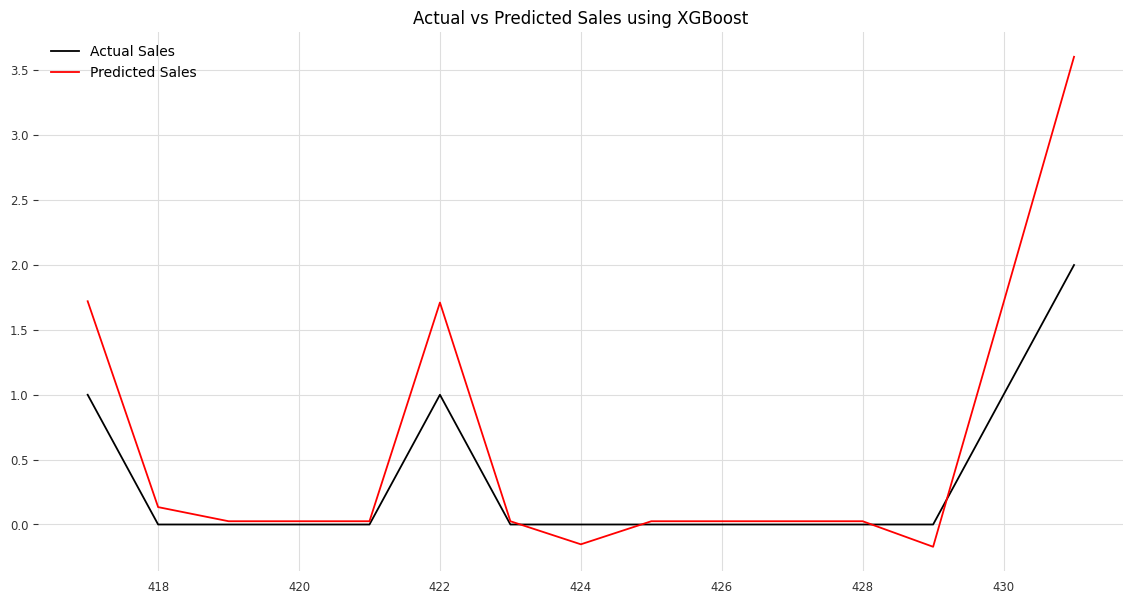

In [275]:
i = 15 # number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label='Actual Sales')
plt.plot(y_test.index[:i], y_pred[:i], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

In [286]:
# Initializing the model
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid, trying 3 values for each parameter
param_grid = {
    'eta': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'n_estimators': [100, 200, 300]
}

# Time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=xgboost_model,
                                   param_distributions=param_grid,
                                   cv=tscv,
                                   n_iter=10,
                                   scoring='neg_mean_squared_error' # this is the MSE metric
                                  )

# Fit the model and search for the best hyperparameters
random_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = random_search.best_params_
print("Best Parameters for XGBoost:", best_params)

Best Parameters for XGBoost: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 5, 'eta': 0.1, 'colsample_bytree': 1.0}


In [280]:
best_model = random_search.best_estimator_

In [283]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

In [284]:
print("R2:", r2_score(y_true=y_test, y_pred=y_pred))
print("MAE:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

R2: 0.47590625528521613
MAE: 0.7664146843065636


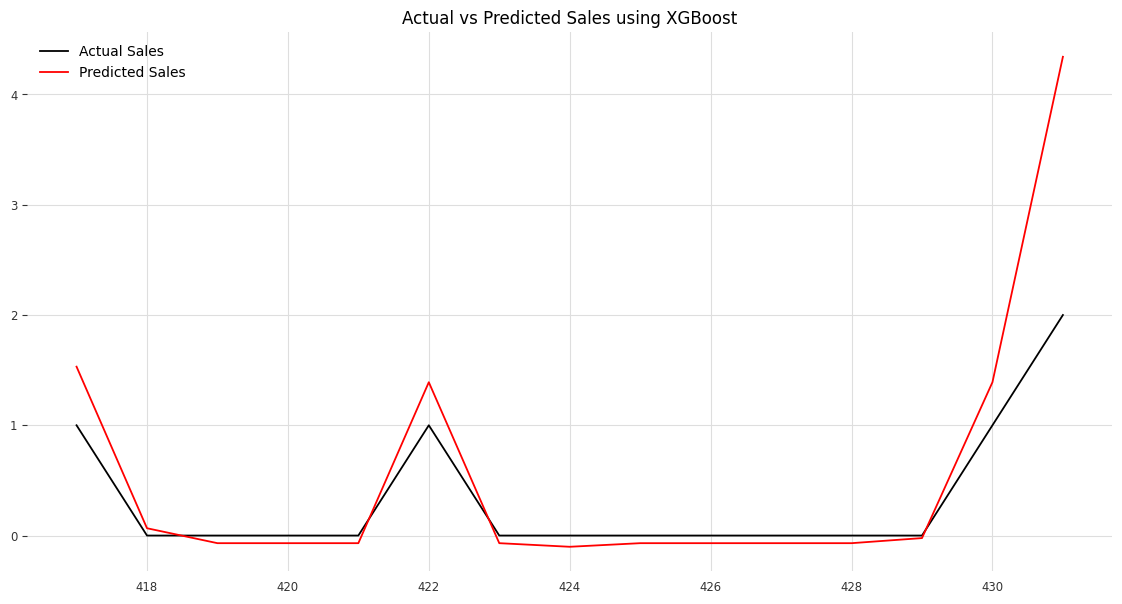

In [285]:
i = 15 # number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label='Actual Sales')
plt.plot(y_test.index[:i], y_pred[:i], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

In [ ]:
# defining a path where we are going to save our model to
pickle_path = '/Users/lukasfichtner/Documents/VS Code Workspace/favorita-grocery-sales-forecasting'

# saving our best model
with open(pickle_path, 'wb') as f:
    pickle.dump({'df_train': df_train, 'df_test': df_test, 'best_model': best_model}, f)

print(f"Model saved as pickle file at: {pickle_path}")

## 6.LSTM Model

In [ ]:
i = 15 # number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label='Actual Sales')
plt.plot(y_test.index[:i], y_pred[:i], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

In [ ]:
# Group by date and aggregate sales for each day
df_boost = df_boost.groupby('date').sum()['unit_sales'].reset_index()
# Fill missing dates with zero sales (since some dates may have no sales)
df_boost = df_boost.set_index('date')
df_boost = df_boost.asfreq('D').fillna(0)

In [ ]:
# Convert to a Darts TimeSeries object
series = TimeSeries.from_dataframe(df_boost, value_cols='unit_sales')


In [ ]:
df_boost

In [ ]:
# Visualize the new features alongside the original sales
df_boost[['unit_sales', 'rolling_mean_7', 'rolling_std_7']].plot(figsize=(14, 7))
plt.title('Original Sales, 7-day Rolling Mean, and 7-day Rolling Std Dev')
plt.show()

In [ ]:
df_boost.head()

In [ ]:
# For time series, use date-based splitting instead of random splitting
split_date = '2014-03-01'

# Create features and target
X = df_boost.drop('unit_sales', axis=1)
y = df_boost['unit_sales']

# Split based on date index
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

### 2. Implementing XGBoost for TimeSeries Forecasting

In [ ]:
reg = xgb.XGBRegressor(
    n_estimators=1000,
    early_stopping_rounds=50 # if model doesn't improve, we stop
)

reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False  # Change verbose to True if you want to see how the model gets trained
)

In [ ]:
plot_importance(reg, height=0.9);


In [ ]:
df_boost_opt = df_train[['date','unit_sales','lag_1','lag_7','lag_30','rolling_mean_7','rolling_std_7',
                     'sales_change_7d','is_holiday','dcoilwtico']] 
df_boost_opt = df_boost_opt.set_index('date')

In [ ]:
# For time series, use date-based splitting instead of random splitting
split_date = '2014-03-01'

# Create features and target
Xo = df_boost_opt.drop('unit_sales', axis=1)
yo = df_boost_opt['unit_sales']

# Split based on date index
X_train_o = Xo[Xo.index < split_date]
X_test_o = Xo[Xo.index >= split_date]
y_train_o = yo[yo.index < split_date]
y_test_o = yo[yo.index >= split_date]

In [ ]:
reg = xgb.XGBRegressor(
    n_estimators=1000,
    early_stopping_rounds=50 # if model doesn't improve, we stop
)

reg.fit(
    X_train_o,
    y_train_o,
    eval_set=[(X_train_o, y_train_o), (X_test_o, y_test_o)],
    verbose=False  # Change verbose to True if you want to see how the model gets trained
)



### 3.Plotting Actual vs Predicted Values

In [ ]:
y_train_o

In [ ]:
X_test_o['sales_prediction'] = reg.predict(X_test_o)
res = pd.concat([X_test_o, y_train_o], sort=False)

In [ ]:
res.head()

In [ ]:
plt.plot(res)

In [ ]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test.values, label='Actual Sales')
plt.plot(y_test.index, y_pred, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()